# Create a RNN model to text generation
- RNN model at character level
    - Input: n character previous
    - Output: next character
    - Model LSTM
- Use 'El Quijote' to train the generator


In [1]:
# Header
import numpy as np

path = '/home/ubuntu/data/training/keras/'

## Download data and generate sequences

Download quijote from guttenberg project


wget http://www.gutenberg.org/cache/epub/2000/pg2000.txt

In [2]:
#Read book
text = open(path + "pg2000.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('Chars list: ', chars)
print('total chars:', len(chars))

#Dictionaries to convert char to num & num to char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


('corpus length:', 2198927)
('Chars list: ', ['\n', '\r', ' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x81', '\x89', '\x8d', '\x91', '\x93', '\x9a', '\xa0', '\xa1', '\xa9', '\xab', '\xad', '\xaf', '\xb1', '\xb3', '\xb9', '\xba', '\xbb', '\xbc', '\xbf', '\xc2', '\xc3', '\xef'])
('total chars:', 80)


In [3]:
# cut the text in semi-redundant sequences of maxlen characters
# One sentence of length 20 for each 3 characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(300, len(text) - maxlen, step): #Start in line 30 to exclude Gutenberg header.
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
print sentences[4996], '-', next_chars[4996]

('nb sequences:', 732869)
e nombre el río taj - o


## Train the model

In [23]:
'''
X: One row by sentence
    in each row a matrix of bool 0/1 of dim length_sentence x num_chars coding the sentence. Dummy variables
y: One row by sentence
    in each row a vector of bool of lengt num_chars with 1 in the next char position
'''

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('X shape: ',X.shape)
print('y shape: ',y.shape)

Vectorization...
('X shape: ', (732869, 20, 80))
('y shape: ', (732869, 80))


In [24]:
# build the model: 2 stacked LSTM
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM


print('Build model 1')
seq_prev_input = Input(shape=(maxlen, len(chars)), name='prev') 
                
# apply forwards LSTM
forwards1 = LSTM(512, dropout_W=0.3, dropout_U=0.3, return_sequences=True)(seq_prev_input)

forwards2 = LSTM(512, dropout_W=0.3, dropout_U=0.3, return_sequences=False)(forwards1)

output = Dense(len(chars), activation='softmax')(forwards2)

model1 = Model(input=seq_prev_input, output=output)
model1.summary()

# try using different optimizers and different optimizer configs
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Build model 1
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
prev (InputLayer)                (None, 20, 80)        0                                            
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 20, 512)       1214464     prev[0][0]                       
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 512)           2099200     lstm_3[0][0]                     
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 80)            41040       lstm_4[0][0]                     
Total params: 3354704
_______________________________________________________

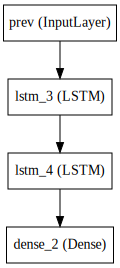

In [25]:
#Print the model
#Plot the model graph
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [26]:
#Fit model
history = model1.fit(X[:600000], y[:600000], batch_size=512, nb_epoch=30,
           validation_data=(X[600000:], y[600000:]))



Train on 600000 samples, validate on 132869 samples
Epoch 1/30
600000/600000 [==============================] - 523s - loss: 2.2971 - acc: 0.3154 - val_loss: 1.9305 - val_acc: 0.4111
Epoch 2/30
600000/600000 [==============================] - 522s - loss: 1.8107 - acc: 0.4357 - val_loss: 1.7215 - val_acc: 0.4805
Epoch 3/30
600000/600000 [==============================] - 522s - loss: 1.6351 - acc: 0.4875 - val_loss: 1.6226 - val_acc: 0.5123
Epoch 4/30
600000/600000 [==============================] - 522s - loss: 1.5340 - acc: 0.5168 - val_loss: 1.5604 - val_acc: 0.5306
Epoch 5/30
600000/600000 [==============================] - 522s - loss: 1.4689 - acc: 0.5361 - val_loss: 1.5244 - val_acc: 0.5443
Epoch 6/30
600000/600000 [==============================] - 522s - loss: 1.4232 - acc: 0.5494 - val_loss: 1.5053 - val_acc: 0.5508
Epoch 7/30
600000/600000 [==============================] - 523s - loss: 1.3890 - acc: 0.5596 - val_loss: 1.4823 - val_acc: 0.5579
Epoch 8/30
600000/600000 [=====

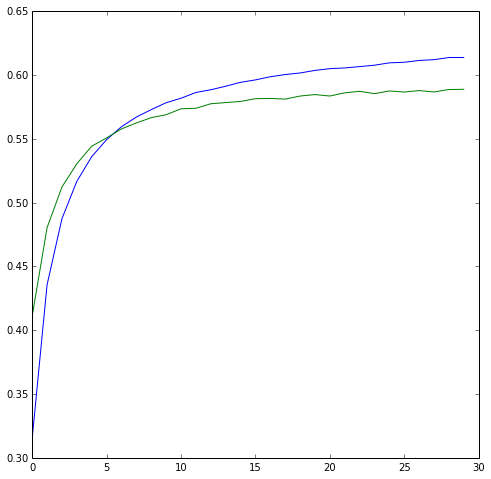

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [29]:
#Save model
model_name = 'text_generation_model1'

json_string = model1.to_json()
open(path + 'models/mdl_' + model_name + '.json', 'w').write(json_string)
model1.save_weights(path + 'models/w_' + model_name + '.h5')

[WARNING] /home/ubuntu/data/training/keras/models/w_text_generation_model1.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!


## Evaluate model

In [4]:
# Load model
from keras.models import model_from_json

model_name = 'text_generation_model1'

model1 = model_from_json(open(path + 'models/mdl_' + model_name + '.json').read())
model1.load_weights(path + 'models/w_' + model_name + '.h5')

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [17]:
maxlen = 20


def sample(a, diversity=1.0):
    '''
    helper function to sample an index from a probability array
    - Diversity control the level of randomless
    '''
    a = np.log(a) / diversity
    a = np.exp(a) / np.sum(np.exp(a), axis=0)
    a /= np.sum(a+0.0000001) #Precission error
    return np.argmax(np.random.multinomial(1, a, 1))


def generate_text(sentence, diversity, current_model, num_char=400):
    sentence_init = sentence
    generated = ''
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = current_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    print()
    print('DIVERSITY: ',diversity)
    print(sentence_init + generated)


In [18]:

sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



sentence = 'de lo que sucedió a'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



sentence = 'de allí a poco come'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


()
('DIVERSITY: ', 0.2)
mire vuestra merced a los demás de la mano de la mano de los dos de la mano de la mano de la mano de la mano, y que le diese la mano de la cabeza de la mano de la mano de la cabeza, y a los demás de la cabeza, y adonde se le había de ser mano a la memoria del cabrero, y aun a los demás de los dos de los demás de los demás de los demás de la mujer y desde aquí a la mano, y que no se hallará mucha cosa de la m
()
('DIVERSITY: ', 0.5)
mire vuestra merced sería que no sobre buen hombre que debe de ser alguna de un mundo que no le habéis de ser muy bien con sus manos, que se los hagan los ojos de los pensamientos de los caballeros andantes y
malambrunos de los libros de amor y verdaderamente ha de ser mejor que tenga tal trasletado en un caballero andante caballero andante, que el más deste mal de los dos de la cuadrilla de la vida había de ser
()
('DIVERSITY: ', 1)
mire vuestra merced que las cosas fue como continente, la famuna del arriero, sin duda
repreventan. só